# Figure 6

## Caution:
- You need to run <code>python eeg_cleaning.py</code> and <code>python eeg_fc.py</code> (in that order) in a terminal prior to running this program. 

## Info:
- The statistics in section 4.3 are generated here (p-values, Cohen's $d$) and are saved in the <code>Figure6</code> directory.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
from scipy.stats import sem
import seaborn as sns
import pandas as pd
from statannotations.Annotator import Annotator
from scipy.stats import ttest_rel, wilcoxon, shapiro
from statsmodels.stats.multitest import fdrcorrection
from math import sqrt
from functions import make_directory

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'arial'
np.set_printoptions(suppress=True)

In [2]:
methods = ['CSS', 'NMI', 'ALE', 'MSC', 'IC', 'WPLI', 'PCC']
levels = ['easy', 'hard']
bands = ['theta']
pvalue_thresholds =[[1e-4, "***"], [1e-3, "***"], [1e-2, "**"], [0.05, "*"]]

def get_net_lst(band, level, method, is_ica, ica_flag):
    res = []
    path = f'EEG_SPI_results/{level}/{band}/{method}'
    
    for i in range(n_subjects):
        s = str(i+1).zfill(2)
        for j in range(n_sessions):
            m = np.loadtxt(f'{path}/sub{s}_se{j+1}{is_ica}.csv', delimiter=',')
            dia_sum = sum(np.diagonal(m))
            off_dia_sum = np.sum(m) - dia_sum
            mean = off_dia_sum / (m.size - len(np.diagonal(m)))
            res.append([band, level, method, 'FP', mean, ica_flag])
            
    return res

n_subjects, n_sessions = 29, 3
data = []
for ica_status in ['', '_noica']:
    for band in bands:
        for level in levels:
            print(f'band: {band}, level: {level}')
            for method in methods:
                ica_flag = True if ica_status == '' else False
                data.extend(get_net_lst(band, level, method, ica_status, ica_flag))

df = pd.DataFrame(data=data, 
              columns=['band','level','method','network','score','ICA used'])

band: theta, level: easy
band: theta, level: hard
band: theta, level: easy
band: theta, level: hard


In [3]:
pvals, effect_sizes = [], []
ica_flags = [False, True]
path = 'Figure6'
make_directory(path)

for i in range(len(ica_flags)):
    flag = ica_flags[i]

    for method in methods:
        sub = df.loc[(df['band'] == band) & (df['ICA used'] == flag) & (df['method'] == method)]
        a = sub.loc[sub['level'] == 'easy']['score'].to_numpy()
        b = sub.loc[sub['level'] == 'hard']['score'].to_numpy()
        size = (np.mean(a) - np.mean(b)) / np.std(a - b) # Cohen's d effect size
        effect_sizes.append(size)

        if (shapiro(a).pvalue < 0.05 or shapiro(b).pvalue < 0.05):
            pvals.append(wilcoxon(a, b).pvalue)
        else:
            pvals.append(ttest_rel(a,b).pvalue)

#print("before:", pvals)
pvals = fdrcorrection(pvals)[1]
#print("pval length:", len(pvals), "after:", pvals)
np.savetxt(f'{path}/pvals.csv', pvals, delimiter=',')
#print("effect length:", len(effect_sizes), "sizes:", effect_sizes)
np.savetxt(f'{path}/effect_sizes.csv', effect_sizes, delimiter=',')

p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
     ***: p <= 1.00e-04

easy vs. hard: Custom statistical test, P_val:1.864e-10
p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
     ***: p <= 1.00e-04

p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
     ***: p <= 1.00e-04

easy vs. hard: Custom statistical test, P_val:4.291e-12
p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
     ***: p <= 1.00e-04

easy vs. hard: Custom statistical test, P_val:4.291e-12
p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
     ***: p <= 1.00e-04

easy vs. hard: Custom statistical test, P_val:3

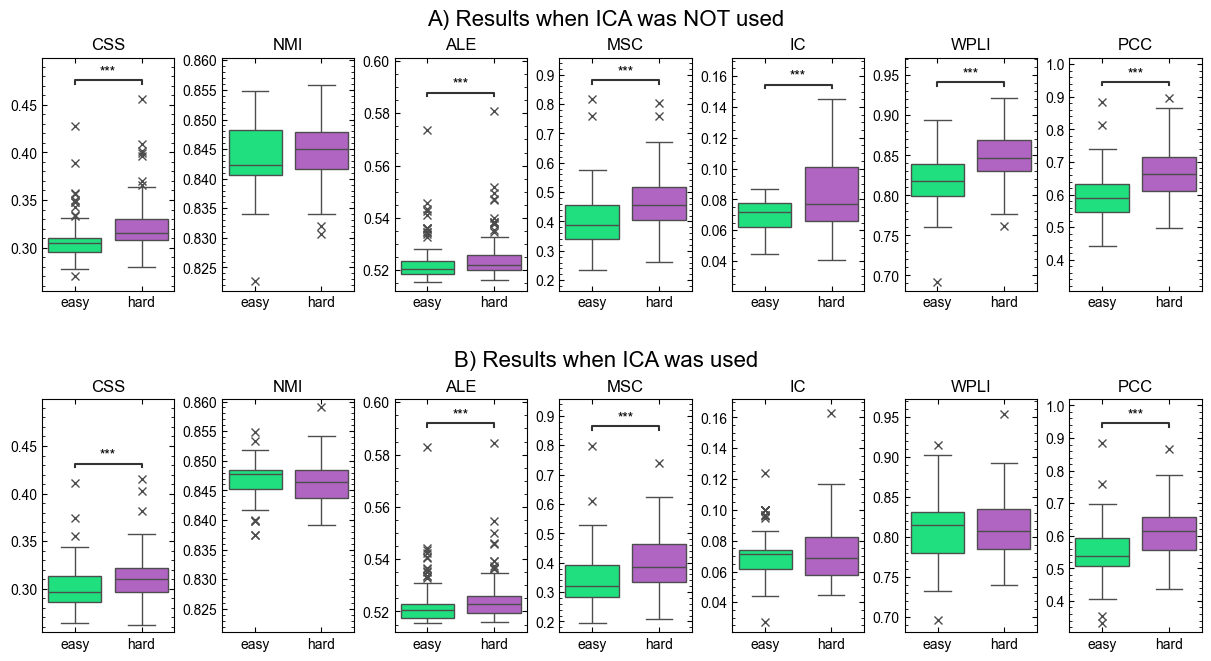

In [4]:
palette = ['springgreen', 'mediumorchid']
headers, ica_info = ['A)', 'B)'], [' NOT', '']
nums = [[] for _ in range(len(methods))]
plot = 'boxplot'
# can enable this if you want to see the means on boxplot
#meanprops = dict(marker='.', markeredgecolor='black', markerfacecolor='black')

for band in bands:
    fig = plt.figure(constrained_layout=True, figsize=(12, 6.5))
    subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0.1)
    fig_axes = []

    i = 0
    for row, subfig in enumerate(subfigs):
        s, ica_ctrl, flag = headers[i], ica_info[i], ica_flags[i]
        subfig.suptitle(fr'{s} Results when ICA was{ica_ctrl} used', fontsize=16)
        axs = subfig.subplots(nrows=1, ncols=len(methods), sharey=False)
        fig_axes.append(axs)
        
        dodge, errwidth, scale, capsize = 0, 0.5, 1, 0.05
        for j in range(len(methods)):
            method = methods[j]
            subset = df.loc[(df['ICA used'] == flag) & (df['method'] == method)]
            x, y, hue = 'level', 'score', 'level'
            sns.boxplot(subset, ax=axs[j], x=x, y=y, hue=x, palette=palette,
                        flierprops={"marker": "x"},
                        #showmeans=True,meanprops=meanprops
                        ) 

            pairs = [('easy','hard')]
            annotator = Annotator(axs[j], pairs, data=subset, x=x, y=y, plot=plot)
            annotator.configure(test=None, pvalue_thresholds = pvalue_thresholds,
                               hide_non_significant=True)
            annotator.set_pvalues([pvals[j + i*int(len(pvals)/2)]])
            annotator.annotate()
    
            col = axs[j]
            col.set_xlabel(None)
            col.set_ylabel(None)
            col.set_title(method, fontsize=12)
            col.yaxis.minorticks_on()
            col.tick_params(which='both', direction = 'in', right=True, top=True)
            bottom, top = col.get_ylim()
            nums[j].append([bottom, top])
            
        i += 1
        
    for j in range(len(methods)):
        a = np.transpose(nums[j])
        fig_axes[0][j].set_ylim(min(a[0]), max(a[1]))
        fig_axes[1][j].set_ylim(min(a[0]), max(a[1]))
        
    plt.savefig(f'Figure6/Figure6_{band}.eps',  bbox_inches='tight')
    plt.savefig(f'Figure6/Figure6_{band}.pdf',  bbox_inches='tight')
    plt.savefig(f'Figure6/Figure6_{band}.png', dpi=500, bbox_inches='tight')
    plt.show()